In [1]:
%matplotlib notebook

import strawb
from strawb.sensors.lidar.laser_adjustment_scan import LaserAdjustmentScan
import pandas 

import glob
import numpy as np
from matplotlib import pyplot as plt
#import matplotlib.colors as colors
width  = 9.5
height = width / 1.618
figsize = np.array((width,height))

#import plotly.express as px
#from plotly.subplots import make_subplots
#import plotly.graph_objects as go
#import plotly.io as pio

#import datetime

# set plotly default to plotly_white and define a presonal colorway
#pio.templates["myname"] = go.layout.Template(
#    layout=go.Layout(
#        colorway=px.colors.qualitative.T10,  # colors
#        yaxis = dict(exponentformat = 'SI'),  # exponentformat to SI, i.e., 1e9 -> 1G
#    ))
#pio.templates.default = "plotly_white+myname"  # 'plotly_white' and overwrite with the pramters in 'myname'

# Get files from DB

Get all laser scan files with file-version >=3 


In [16]:
db = strawb.SyncDBHandler(file_name='Default')  # loads the db

# mask by device
mask = db.dataframe['deviceCode'] == 'TUMLIDAR001'
mask |= db.dataframe['deviceCode'] == 'TUMLIDAR002'

# and add mask by 'measurement_type'
mask &= db.dataframe['measurement_type'] == 'laser_adjustment'

#to only get the current measurements, compliant with file_version >= 3
mask &= db.dataframe['measurement_steps'] == 10
mask &= db.dataframe['measurement_duration'] == 2.0

df = db.dataframe[mask]

# Analysis
1. Initiate lidar with one file of the Dataframe
2. loop over all files in the Dataframe and compute the max positions, theta, phi and measurement value
3. can't store 2d arrays in datebase, so only max step positions and the date can be stored there

In [17]:
ana = LaserAdjustmentScan(df.index[-1])

In [18]:
measured_signal_arr = []
computed_angles_arr = []
datefrom = []
max_step_positions = []

for file, row in df.iterrows():
    ana.file = file
    
    measured_signal = ana.laser_adjustment_return()
    comp_ang = ana.get_angles()
    max_steps = ana.get_steps_from_max_value()
    
    measured_signal_arr.append(measured_signal)
    computed_angles_arr.append(comp_ang)
    max_step_positions.append(max_steps)
    datefrom.append(row["dateFrom"])
    
measured_signal_arr = np.array(measured_signal_arr)
computed_angles_arr = np.array(computed_angles_arr)
max_step_positions = np.array(max_step_positions)    
datefrom = np.array(datefrom) 

df_steps = pandas.DataFrame(dict(steps_x=max_step_positions[:,0], 
                                 steps_y=max_step_positions[:,1],
                                 datefrom=df["dateFrom"],
                                 whichlidar=df["deviceCode"]
                                ))

# Plotting Signal

<IPython.core.display.Javascript object>


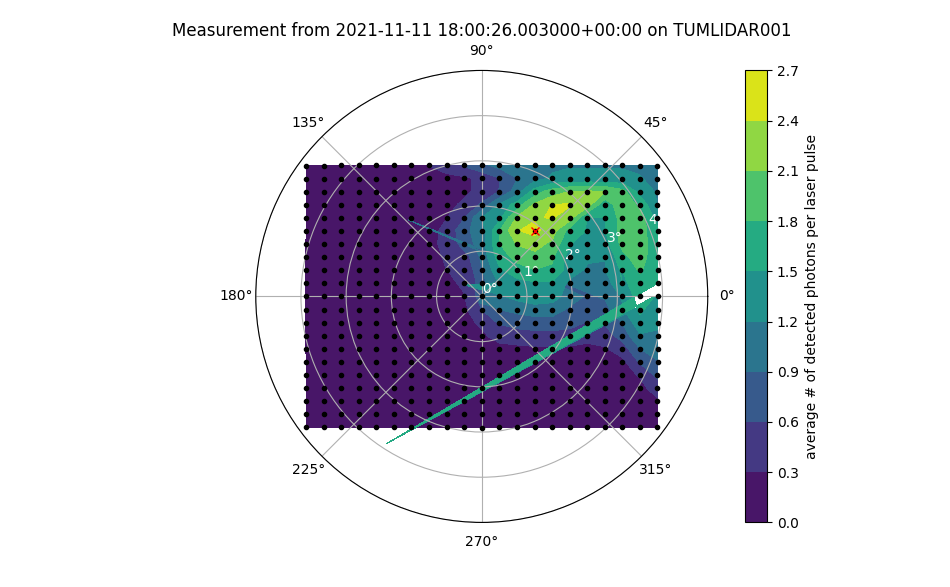

In [20]:
fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(111, polar=True)
rad2deg = 180/np.pi

ind = -2

measured_signal = measured_signal_arr[ind]
phi_2d = computed_angles_arr[ind,0]
theta_2d = computed_angles_arr[ind,1]
date = df_steps["datefrom"].iloc[ind]
whichlidar = df_steps["whichlidar"].iloc[ind]

maxind = np.unravel_index(measured_signal.argmax(), measured_signal.shape)

# --- plot measured data ---
c = ax.contourf(phi_2d,theta_2d*rad2deg, measured_signal, levels=8, cmap='viridis')

# --- plot the angles of the direction from the laser at which the measurement was performed ---
ax.plot(phi_2d.flatten(),theta_2d.flatten()*rad2deg, 'k.')
ax.plot(phi_2d[maxind].flatten(),theta_2d[maxind].flatten()*rad2deg, 'rx')

# --- update r-ticks and labels, to represent theta
m = np.max(theta_2d*rad2deg)
ticks = np.arange(0,np.ceil(m) + 1)
labels = []
for i in ticks:
    labels.append(f'{i:.0f}°')
    
cbar = fig.colorbar(c)
cbar.set_label("average # of detected photons per laser pulse")
ax.tick_params(axis='y', colors='white')

ax.set_yticks(ticks)
ax.set_yticklabels(labels)
plt.title(f'Measurement from {date} on {whichlidar}')
#ax.grid()
plt.show()